In [1]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.stats import multivariate_normal
from scipy.stats import tmean, tstd
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from IPython.display import HTML

from pyDOE import *
import gpflow as gp
from scipy.spatial import distance_matrix

plt.style.use('seaborn-darkgrid')
#sns.set()
sns.set_context("talk")
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from enkf.utils import *

In [3]:
from enkf.enki import *

#  Problem setup 

In [4]:
n_obs = 10                          # number of observations
p = 2                               # dimensionality 
u_star = np.array([[-1], [2]])      # true parameters
noise = .1                         # observational noise, assumed iid
Gamma = noise * np.eye(n_obs)

# Generate dataset
np.random.seed(1)
A = np.concatenate([np.ones([n_obs,1]), 2 * np.random.normal(0, 1, [n_obs, 1])], axis = 1)
y_obs = np.matmul(A, u_star) + np.sqrt(noise) * np.random.normal(0, 1, [n_obs,1])
y_obs = y_obs.flatten()

In [5]:
# Forward model
def linear(u, flag_noise = False):
    return np.matmul(A, u) + flag_noise * np.sqrt(.1) * np.random.normal()

# Ensemble Kalman Inversion

In [6]:
J = 50          # Number of ensemble particles
U0 = np.random.normal(0, 1, [p, J]) 
Jnoise = np.linalg.cholesky(Gamma)

In [7]:
enki_linear = flow(p = p, n_obs = n_obs, J = J)
enki_linear.ustar = u_star
enki_linear.mu = 0.0 * np.array([1., 1.]).reshape(2,-1)
enki_linear.sigma = 100.
enki_linear.run(y_obs, U0, linear, Gamma, Jnoise)

100%|██████████| 30/30 [00:03<00:00,  7.32it/s]


In [8]:
xs, ys = np.meshgrid(np.linspace(-5, 5, 60),
                   np.linspace(-5, 5, 60))

Gs = enki_linear.Gpar(np.array([xs.flatten(), ys.flatten()]), linear)

Hs = ((Gs-y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, Gs-y_obs[:,np.newaxis])).sum(axis = 0)

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10, 10));

cmap = plt.get_cmap('pink')
#cf = plt.contourf(xs, ys, Hs.reshape(60, 60) + \
#                  ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2)), 
#                  np.percentile(Hs + ((xs.flatten()-enki_linear.mu[0])**2 + \
#                                      (ys.flatten()-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2)), range(0,101,10)), 
#                  cmap = cmap)

cf = plt.contourf(xs, ys, np.log(Hs.reshape(60, 60) + \
                ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2))), 
                  cmap = cmap)


scat = []
scat.append(ax.scatter([],[])) ;

def animate(i):
    scat[0].set_offsets(np.c_[enki_linear.Uall[i,0,:], enki_linear.Uall[i,1,:]]);

plt.close()

anim = animation.FuncAnimation(fig, animate, frames = range(enki_linear.T))
HTML(anim.to_html5_video())

In [10]:
print('Posterior covariance matrix:\n')
print(np.linalg.inv(A.T.dot(A)/noise + np.identity(p)/(enki_linear.sigma**2)))
Sigma_n = np.linalg.inv(A.T.dot(A)/noise + np.identity(p)/(enki_linear.sigma**2))

print('\nPosterior mean:\n')

uhat = np.linalg.solve(A.T.dot(A), A.T.dot(y_obs))

print(Sigma_n.dot(A.T.dot(A).dot(uhat)/noise + enki_linear.mu.flatten()/(enki_linear.sigma**2)))


Posterior covariance matrix:

[[0.01006653 0.00034247]
 [0.00034247 0.00176275]]

Posterior mean:

[-1.03673079  2.08697021]


In [11]:
print('Ensemble covariance matrix:\n')
print(np.cov(enki_linear.Uall[-1]))

print('\nEnsemble mean:\n')
print(enki_linear.Uall[-1].mean(axis = 1))

Ensemble covariance matrix:

[[0.01479177 0.00075694]
 [0.00075694 0.00280557]]

Ensemble mean:

[-0.99250478  2.09990603]


# GP emulation

In [12]:
def emulate(enki):
    enki.gpmodels = []

    for ii, y in enumerate(enki.Gstar[range(enki.n_obs)]):
        with gp.defer_build():
            k = gp.kernels.Matern32(input_dim = enki.p, ARD = True)
            #k = gp.kernels.Polynomial(degree = 2., input_dim = self.p, ARD = True)
            m0 = gp.mean_functions.Linear([[1.],[1.]])
            # m0 = gp.mean_functions.Constant()
            m = gp.models.GPR(enki.Ustar.T, y[:,np.newaxis], k)

            # This prior is good for data in a 2 units scale.
            # m.kern.lengthscales.prior = gp.priors.Gamma(1.4942, 1/5.66074)

            # m.kern.lengthscales.prior = gp.priors.Gamma(1.22449, 1/17.1193)
            # m.kern.lengthscales.prior = gp.priors.Gamma(1.10318, 1/10.7495)
            # m.likelihood.variance.trainable = False
            # m.likelihood.variance = 1.0

        m.compile()
        gp.train.ScipyOptimizer().minimize(m);

        enki.gpmodels.append(m)

In [13]:
emulate(enki_linear)

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -263.898211
  Number of iterations: 66
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -263.898211
  Number of iterations: 66
  Number of functions evaluations: 135


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -266.312793
  Number of iterations: 64
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -266.312793
  Number of iterations: 64
  Number of functions evaluations: 124


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -266.529564
  Number of iterations: 63
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -266.529564
  Number of iterations: 63
  Number of functions evaluations: 127


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -264.824750
  Number of iterations: 59
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -264.824750
  Number of iterations: 59
  Number of functions evaluations: 110


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -264.619576
  Number of iterations: 49
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -264.619576
  Number of iterations: 49
  Number of functions evaluations: 106


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -264.140268
  Number of iterations: 73
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -264.140268
  Number of iterations: 73
  Number of functions evaluations: 80


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -263.818779
  Number of iterations: 70
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -263.818779
  Number of iterations: 70
  Number of functions evaluations: 140


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -265.903814
  Number of iterations: 68
  Number of functions evaluations: 131


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -265.903814
  Number of iterations: 68
  Number of functions evaluations: 131


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -267.517591
  Number of iterations: 60
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -267.517591
  Number of iterations: 60
  Number of functions evaluations: 100


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -267.908644
  Number of iterations: 69
  Number of functions evaluations: 177


INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: -267.908644
  Number of iterations: 69
  Number of functions evaluations: 177


In [14]:
from tqdm import tqdm

In [15]:
gplot, varplot = enki_linear.predict_gps(np.vstack([xs.flatten(), ys.flatten()]).T)
gstar, varstar = enki_linear.predict_gps(enki_linear.Ustar.mean(axis = 1).reshape(1, -1))

In [16]:
Hplot = ((gplot - y_obs[:,np.newaxis]) * np.linalg.solve(2 * Gamma, gplot - y_obs[:,np.newaxis])).sum(axis = 0)

In [17]:
Hplot_full = np.empty(shape = Hplot.shape)
Hplot_semi = np.empty(shape = Hplot.shape)

for ii in range(len(varplot.T)):
    Hplot_full[ii] = ((gplot[:,ii] - y_obs) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(varplot[:,ii])), gplot[:,ii] - y_obs)).sum()
    Hplot_semi[ii] = ((gplot[:,ii] - y_obs) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(varstar.flatten())), gplot[:,ii] - y_obs)).sum()

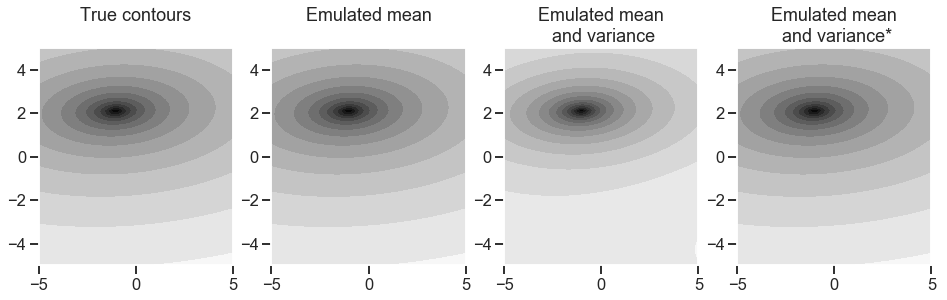

In [18]:
fig, axes = plt.subplots(1,4, figsize = (16, 4));

cmap = plt.get_cmap('gray');
axes[0].contourf(xs, ys, np.log(Hs.reshape(60, 60) + \
                  1.0 * ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2))), 15, 
                  cmap = cmap);
axes[0].set_title('True contours\n');

axes[1].contourf(xs, ys, np.log(Hplot.reshape(60, 60) + \
                  1.0 * ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2))), 15, 
                  cmap = cmap);
axes[1].set_title('Emulated mean\n');

axes[2].contourf(xs, ys, np.log(Hplot_full.reshape(60, 60) + \
                  1.0 * ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2))), 15,
                  cmap = cmap);
axes[2].set_title('Emulated mean\n and variance');

axes[3].contourf(xs, ys, np.log(Hplot_semi.reshape(60, 60) + \
                  1.0 * ((xs-enki_linear.mu[0])**2 + (ys-enki_linear.mu[1])**2)/(2*(enki_linear.sigma**2))), 15,
                  cmap = cmap);
axes[3].set_title('Emulated mean\n and variance*');

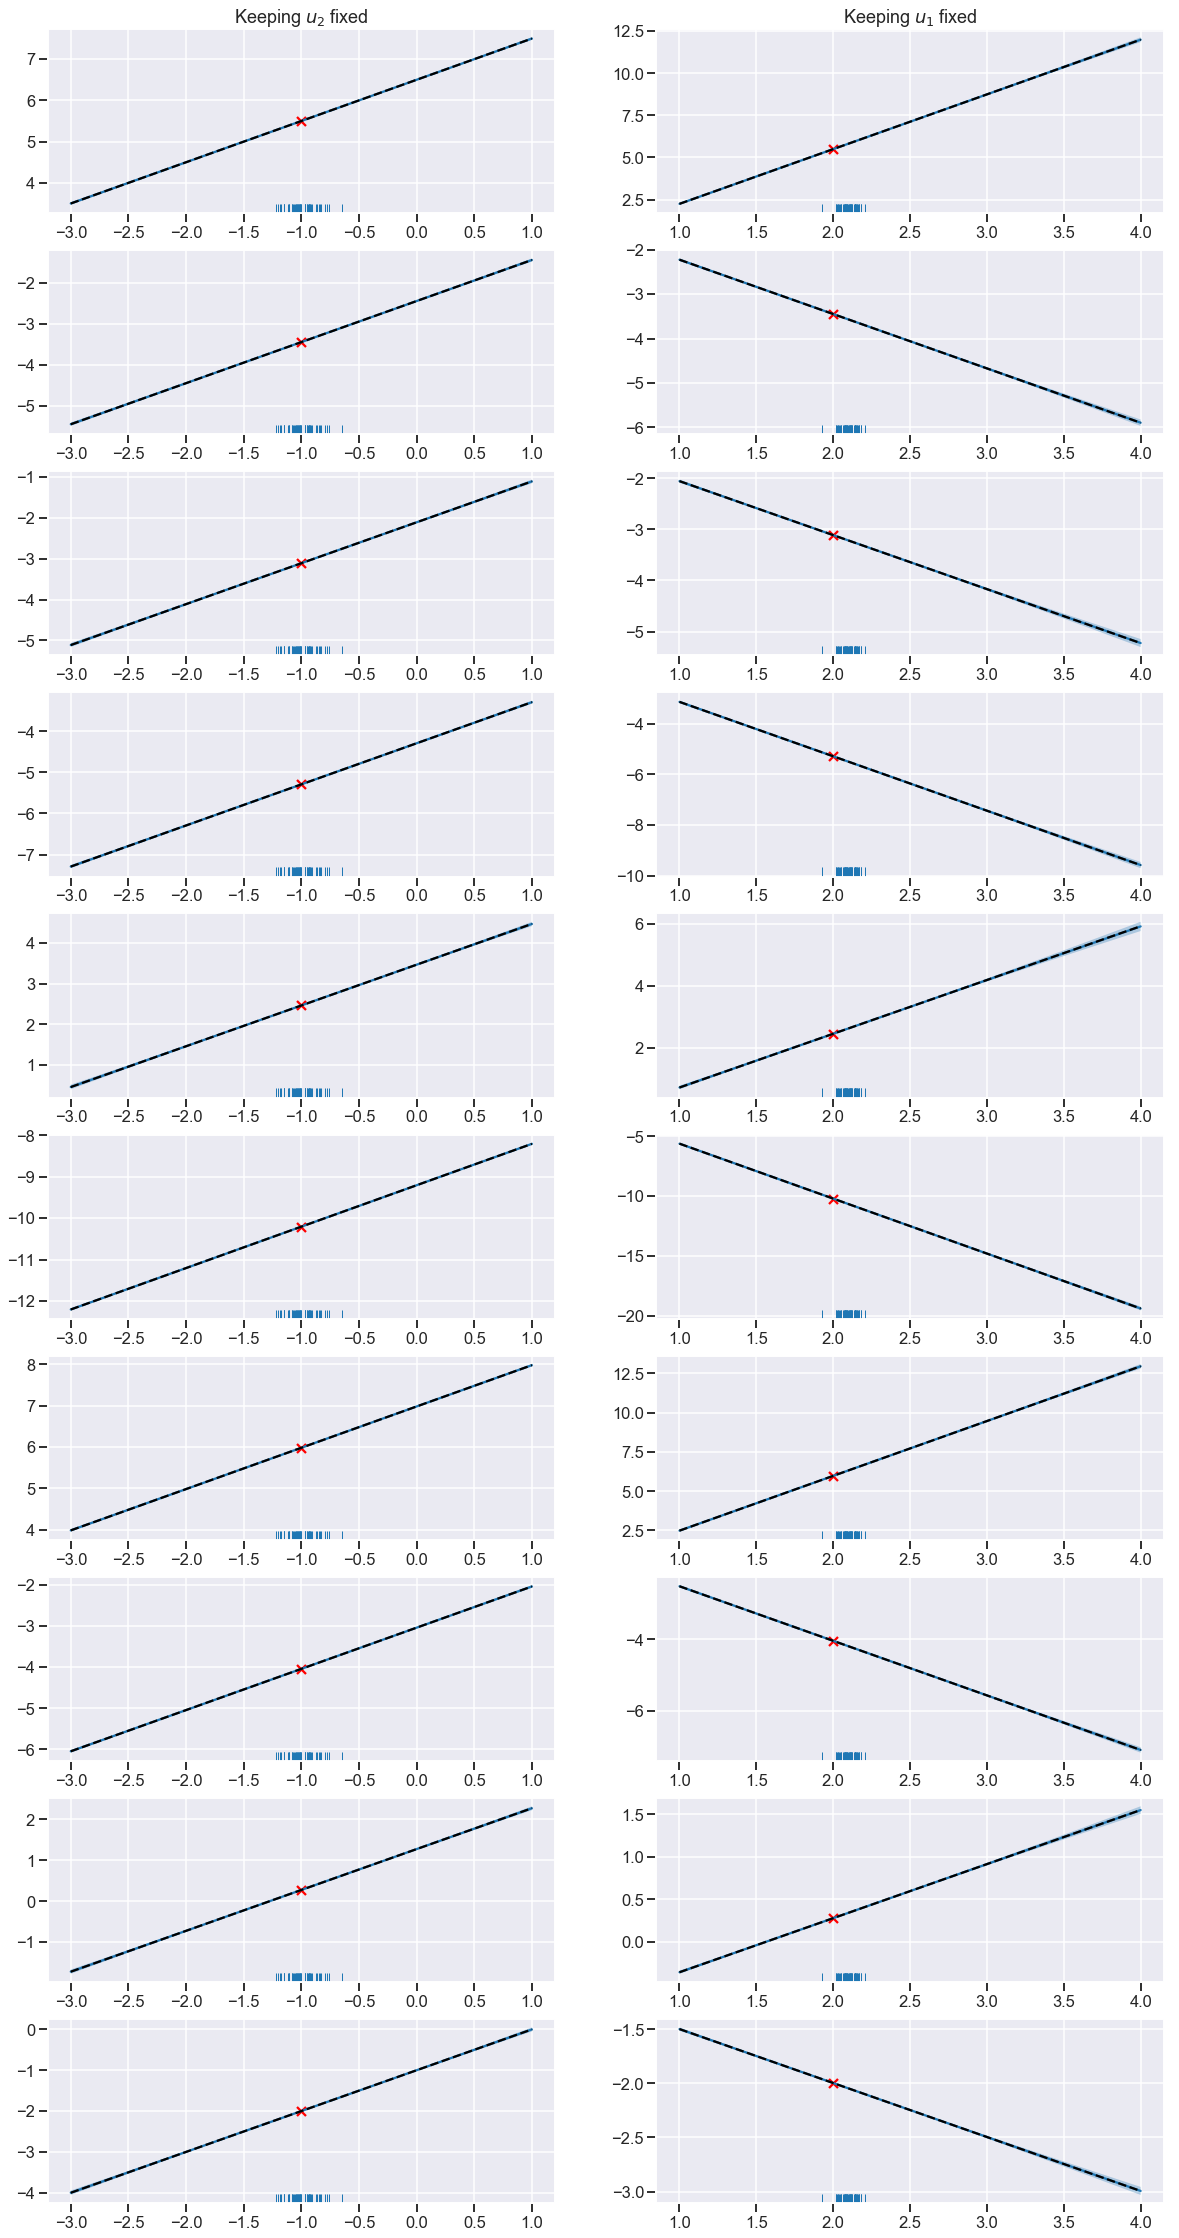

In [19]:
fig, axes = plt.subplots(n_obs, p, figsize = [20, 40])

axes[0,0].set_title('Keeping $u_2$ fixed')
axes[0,1].set_title('Keeping $u_1$ fixed')

for k in range(n_obs):
    theta2 = 2.
    theta1 = np.linspace(-3.0, 1.0)
    gm, gv = enki_linear.gpmodels[k].predict_y(np.vstack([theta1, theta2 * np.ones(theta1.shape)]).T)
    axes[k, 0].plot(theta1, gm)
    axes[k, 0].fill_between( theta1, 
                     (gm + 2 * np.sqrt(gv)).flatten(), 
                     (gm - 2 * np.sqrt(gv)).flatten(), 
                     alpha = 0.3
                    )
    axes[k, 0].plot(theta1, theta1 + theta2 * A[k, 1], 'k--')
    axes[k, 0].scatter(-1, linear([-1,2])[k], color = 'red', marker = "x") 
    twin = axes[k, 0].twinx()
    ax = sns.rugplot(enki_linear.Ustar[0], ax=twin)
    ax.grid(False)
    ax.set_yticks([])
    
    theta1 = -1
    theta2 = np.linspace(1, 4.0)
    gm, gv = enki_linear.gpmodels[k].predict_y(np.vstack([theta1 * np.ones(theta2.shape), theta2]).T)
    axes[k, 1].plot(theta2, gm)
    axes[k, 1].fill_between( theta2, 
                     (gm + 2 * np.sqrt(gv)).flatten(), 
                     (gm - 2 * np.sqrt(gv)).flatten(), 
                     alpha = 0.3
                    )
    axes[k, 1].plot(theta2, theta1 + A[k, 1] * theta2, 'k--')
    axes[k, 1].scatter(2, linear([-1.,2.])[k], color = 'red', marker = "x") 
    twin = axes[k, 1].twinx()
    ax = sns.rugplot(enki_linear.Ustar[1], ax=twin)
    ax.grid(False)
    ax.set_yticks([])
    

# MCMC with independent components

In [20]:
def prior(x, mu, sigma):
    return ((x - mu)**2).sum()/(2*(sigma**2))

In [21]:
n_mcmc = 10000
scales = np.sqrt(np.diag(np.cov(enki_linear.Ustar)))
samples = []
current = enki_linear.Ustar.mean(axis = 1)
flag_noise = False

g = linear(current, flag_noise = flag_noise)
phi_current = ((g - y_obs) * np.linalg.solve(2 * Gamma, g - y_obs)).sum()
phi_current += prior(current, enki_linear.mu.flatten(), enki_linear.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_linear.p)
    
    g_proposal = linear(proposal, flag_noise = flag_noise)
    phi_proposal = ((g_proposal - y_obs) * np.linalg.solve(2 * Gamma, g_proposal - y_obs)).sum()
    phi_proposal += prior(proposal, enki_linear.mu.flatten(), enki_linear.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_truth = np.array(samples)

100%|██████████| 10000/10000 [00:00<00:00, 19570.43it/s]


Acceptance rate: 0.4715


In [22]:
samples_truth_clean = samples_truth.copy()

In [23]:
n_mcmc = 5000
scales = np.sqrt(np.diag(np.cov(enki_linear.Ustar))) * 1
samples = []
current = enki_linear.Ustar.mean(axis = 1)

gmean, gvars = enki_linear.predict_gps(current.reshape(1,-1))
phi_current = ((gmean - y_obs.reshape(-1,1)) * np.linalg.solve(2 * Gamma, gmean - y_obs.reshape(-1,1))).sum()
phi_current += prior(current, enki_linear.mu.flatten(), enki_linear.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_linear.p)
    
    gmean_proposal, gvars_proposal = enki_linear.predict_gps(proposal.reshape(1,-1))
    phi_proposal = ((gmean_proposal - y_obs.reshape(-1,1)) * np.linalg.solve(2 * Gamma, gmean_proposal - y_obs.reshape(-1,1))).sum()
    phi_proposal += prior(proposal, enki_linear.mu.flatten(), enki_linear.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_gp_mean = np.array(samples)

100%|██████████| 5000/5000 [01:44<00:00, 48.05it/s]

Acceptance rate: 0.4754


In [24]:
n_mcmc = 5000
scales = np.sqrt(np.diag(np.cov(enki_linear.Ustar))) * 1
samples = []
current = enki_linear.Ustar.mean(axis = 1)

gmean, gvars = enki_linear.predict_gps(current.reshape(1,-1))
phi_current = ((gmean - y_obs.reshape(-1,1)) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(gvars.flatten())),
                                                               gmean - y_obs.reshape(-1,1))).sum()
phi_current += np.log(0.0 * np.diag(Gamma) + gvars.flatten()).sum()/2
phi_current += prior(current, enki_linear.mu.flatten(), enki_linear.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_linear.p)
    
    gmean_proposal, gvars_proposal = enki_linear.predict_gps(proposal.reshape(1,-1))
    phi_proposal = ((gmean_proposal - y_obs.reshape(-1,1)) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(gvars_proposal.flatten())), 
                                                                             gmean_proposal - y_obs.reshape(-1,1))).sum()
    phi_proposal += np.log(0.0 * np.diag(Gamma) + gvars_proposal.flatten()).sum()/2
    phi_proposal += prior(proposal, enki_linear.mu.flatten(), enki_linear.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_gp_full = np.array(samples)

100%|██████████| 5000/5000 [01:46<00:00, 47.07it/s]

Acceptance rate: 0.437


In [25]:
gstar, varstar = enki_linear.predict_gps(enki_linear.Ustar.mean(axis = 1).reshape(1, -1))

In [26]:
n_mcmc = 5000
scales = np.sqrt(np.diag(np.cov(enki_linear.Ustar))) * 1
samples = []
current = enki_linear.Ustar.mean(axis = 1)

gmean, gvars = enki_linear.predict_gps(current.reshape(1,-1))
phi_current = ((gmean - y_obs.reshape(-1,1)) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(varstar.flatten())),
                                                               gmean - y_obs.reshape(-1,1))).sum()
phi_current += prior(current, enki_linear.mu.flatten(), enki_linear.sigma)

samples.append(current)
accept = 0.

for k in tqdm(range(n_mcmc)):
    proposal = current + scales * np.random.normal(0, 1, enki_linear.p)
    
    gmean_proposal, gvars_proposal = enki_linear.predict_gps(proposal.reshape(1,-1))
    phi_proposal = ((gmean_proposal - y_obs.reshape(-1,1)) * np.linalg.solve(2 * (1.0 * Gamma + np.diag(varstar.flatten())), 
                                                                             gmean_proposal - y_obs.reshape(-1,1))).sum()
    phi_proposal += prior(proposal, enki_linear.mu.flatten(), enki_linear.sigma)

    if np.random.uniform() < np.exp(phi_current - phi_proposal):
        current = proposal
        phi_current = phi_proposal
        accept += 1.
        
    samples.append(current)
    
    
print('Acceptance rate: %s'%(accept/n_mcmc))

samples_gp_semi = np.array(samples)

100%|██████████| 5000/5000 [01:45<00:00, 47.45it/s]

Acceptance rate: 0.482


In [27]:
sns.set_style("ticks")

#sns.set()
sns.set_context("talk")

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


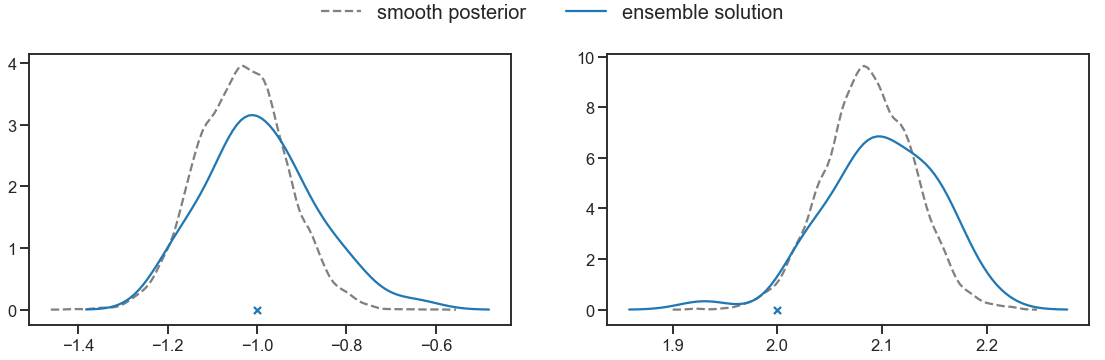

In [28]:
j = 0

fig, axes = plt.subplots(1, p, figsize = (19, 5))

sns.kdeplot(samples_truth_clean[:,j], linestyle = '--', label = 'smooth posterior', ax=axes[j], legend = False, c = 'gray' )
#sns.kdeplot(samples_truth[:,j], label = 'noisy posterior', ax=axes[j], legend = False)
sns.kdeplot(enki_linear.Ustar[j], label = 'ensemble solution', ax=axes[j], legend = False)

axes[j].scatter(np.array(enki_linear.ustar[j]), np.array(0), marker = "x", s = 50);
#axes[0].set_xlim(-3, 1)

for j in range(1, p):
    sns.kdeplot(samples_truth_clean[:,j], linestyle = '--',ax=axes[j], legend = False, c = 'gray' )
#    sns.kdeplot(samples_truth[:,j], ax=axes[j], legend = False)
    sns.kdeplot(enki_linear.Ustar[j], ax=axes[j], legend = False)
    axes[j].scatter(np.array(enki_linear.ustar[j]), np.array(0), marker = "x", s = 50);
    
#axes[1].set_xlim(0, 4)

fig.legend(loc='upper center', ncol = 3, borderaxespad=-.2, 
          shadow = True, fancybox = True, prop={'size': 20});

/Users/agarbuno/anaconda2/envs/gpflow/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


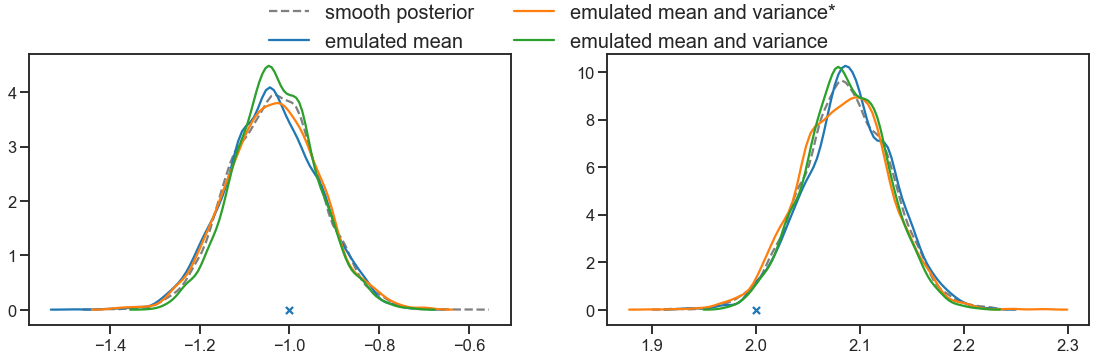

In [29]:
j = 0

fig, axes = plt.subplots(1, p, figsize = (19, 5))

sns.kdeplot(samples_truth_clean[:,j], linestyle = '--', label = 'smooth posterior', ax=axes[j], legend = False, c = 'gray' )
sns.kdeplot(samples_gp_mean[:,j], label = 'emulated mean', ax=axes[j], legend = False)
sns.kdeplot(samples_gp_semi[:,j], label = 'emulated mean and variance*', ax=axes[j], legend = False)
sns.kdeplot(samples_gp_full[:,j], label = 'emulated mean and variance', ax=axes[j], legend = False)

axes[j].scatter(np.array(enki_linear.ustar[j]), np.array(0), marker = "x", s = 50);
#axes[0].set_xlim(-3, 1)

for j in range(1, p):
    sns.kdeplot(samples_truth_clean[:,j], linestyle = '--',ax=axes[j], legend = False, c = 'gray' )
    sns.kdeplot(samples_gp_mean[:,j], ax=axes[j], legend = False)
    sns.kdeplot(samples_gp_semi[:,j], ax=axes[j], legend = False)
    sns.kdeplot(samples_gp_full[:,j], ax=axes[j], legend = False)
    axes[j].scatter(np.array(enki_linear.ustar[j]), np.array(0), marker = "x", s = 50);
    
#axes[1].set_xlim(0, 4)

fig.legend(loc='upper center', ncol = 2, borderaxespad=-.2, 
          shadow = True, fancybox = True, prop={'size': 20});

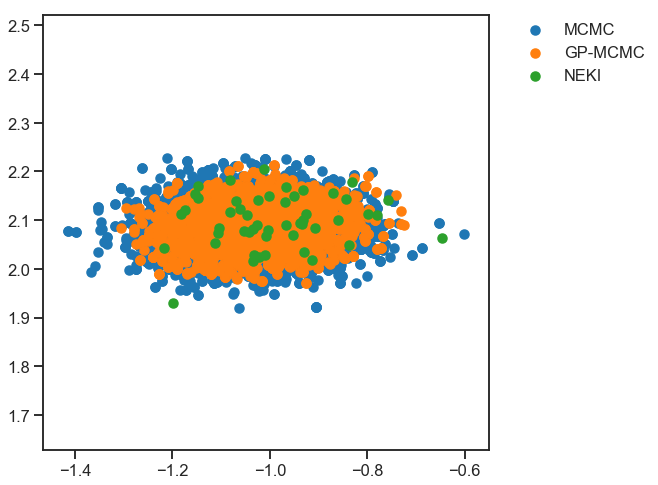

In [30]:
fig, ax = plt.subplots(1,1, figsize = (8, 8));

plt.scatter(samples_truth_clean[:,0], samples_truth_clean[:,1], label = 'MCMC')
plt.scatter(samples_gp_full[:,0], samples_gp_full[:,1], label = 'GP-MCMC')
plt.scatter(enki_linear.Uall[-1][0,:], enki_linear.Uall[-1][1,:], label = 'NEKI')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.axis('equal');